# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

## Step 1. Gaussian filter

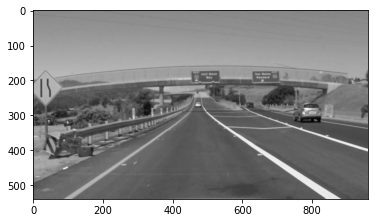

In [ ]:
def padding_img(img,k_size,style='edge'):
  return np.pad(img,k_size,style)

def gaussian_kernel(size):
    sigma=0.3*((size-1)*0.5 - 1) + 0.8
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]   
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2)))     
    return g/np.sum(g)

img_org = cv2.imread("highway.jpg",0)
KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row,col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2,style='reflect')

    for x in range(row):
        for y in range(col):
          respixel=0
          for i in range(KernelSize):
              for j in range(KernelSize):
                  pixel=padimg[x+i,y+j]* Gaussian_Kernel[i][j]
                  respixel+= pixel         
          resx[x,y]=respixel
    return resx

img = Gaussian_Filter(KernelSize,img_org)
plt.imshow(img ,cmap='gray')
plt.show()

In [ ]:
img.shape,img.dtype

((540, 960), dtype('uint8'))

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [ ]:
def sobel(img, filtering_type):
    h, w = img.shape

    horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        
    Gx = np.zeros((h - 2, w - 2))
    Gy = np.zeros((h - 2, w - 2))

    for img_region, i, j in iterate_regions(img, 3):
        if filtering_type == 'dx':
            Gx[i, j] += np.sum(img_region * horizontal)
        elif filtering_type == 'dy':
            Gy[i, j] += np.sum(img_region * vertical)
        elif filtering_type == 'magnitude':
            Gx[i, j] += np.sum(img_region * horizontal)
            Gy[i, j] += np.sum(img_region * vertical)

    gradient = np.sqrt(Gx**2 + Gy**2)
    gradient = np.pad(gradient, (1, 1), 'constant')
    angle = np.arctan2(Gy, Gx)
    angle = np.pad(angle, (1, 1), 'constant')

    output = (255 * np.int32(gradient > 255) + gradient * np.int32(gradient <= 255))
    angle += math.pi * np.int32(angle < 0)

    return output, angle


def iterate_regions(img, kernel_size):
    h, w = img.shape
    for i in range(h - kernel_size + 1):
        for j in range(w - kernel_size + 1):
            img_region = img[i:(i + kernel_size), j:(j + kernel_size)]
            yield img_region, i, j



In [ ]:
sobel_y,_ = sobel(img, 'dy')
sobel_x,_ = sobel(img, 'dx')
sobel_m,_ = sobel(img, 'magnitude')

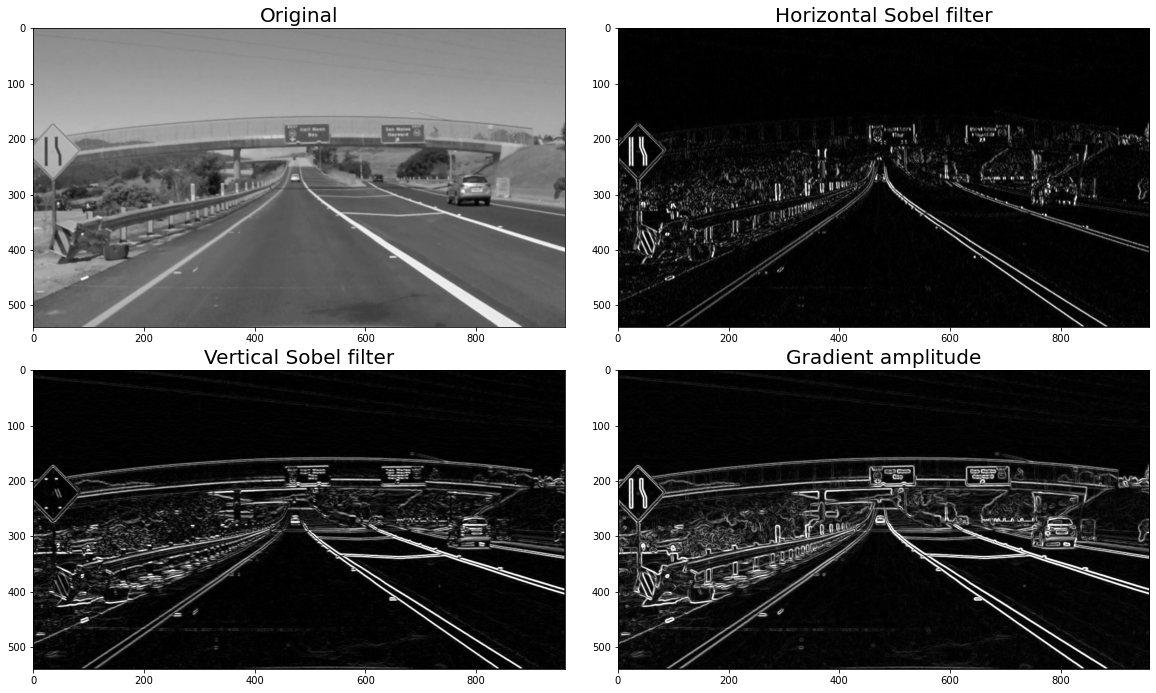

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.subplot(2,2,1)
plt.title('Original' ,fontsize=20)
plt.imshow(img, cmap='gray')

plt.subplot(2,2,2)
plt.title('Horizontal Sobel filter',fontsize=20)
plt.imshow(sobel_x, cmap='gray')

plt.subplot(2,2,3)
plt.title('Vertical Sobel filter',fontsize=20)
plt.imshow(sobel_y, cmap='gray')

plt.subplot(2,2,4)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(sobel_m, cmap='gray')

plt.show()

## Step 3. Non-maximum Suppression
Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [ ]:
def non_maximum_suppression(gradient,angle):
    gradient_copy = gradient.copy()
    height,width= gradient.shape
    for j in range(1, height-1):
        for i in range(1, width-1):
            #0~22.5度，157.5~180度 為 0 度區間
            if (angle[j, i] >= 0 and angle[j, i] < 22.5 / 180 * math.pi) or (angle[j, i] >= 157.5 / 180 * math.pi and angle[j, i] < math.pi):
                if gradient[j, i] < gradient[j, i-1] or gradient[j, i] < gradient[j, i+1]:
                    gradient_copy[j, i] = 0
            #22.5~67.5度 為 45度區間
            elif angle[j, i] >= 22.5 / 180 * math.pi and angle[j, i] < 67.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j-1, i-1] or gradient[j, i] < gradient[j+1, i+1]:
                    gradient_copy[j, i] = 0
            #67.5~112.5度 為 90度區間
            elif angle[j, i] >= 67.5 / 180 * math.pi and angle[j, i] < 112.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j-1, i] or gradient[j, i] < gradient[j+1, i]:
                    gradient_copy[j, i] = 0
            #112.5~157.5度 為 135度區間
            elif angle[j, i] >= 112.5 / 180 * math.pi and angle[j, i] < 157.5 / 180 * math.pi:
                if gradient[j, i] < gradient[j+1, i-1] or gradient[j, i] < gradient[j-1, i+1]:
                    gradient_copy[j, i] = 0            
    # output = np.clip(gradient_copy,0,255)    
    return gradient_copy

gradient,angle = sobel(img, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient,angle)


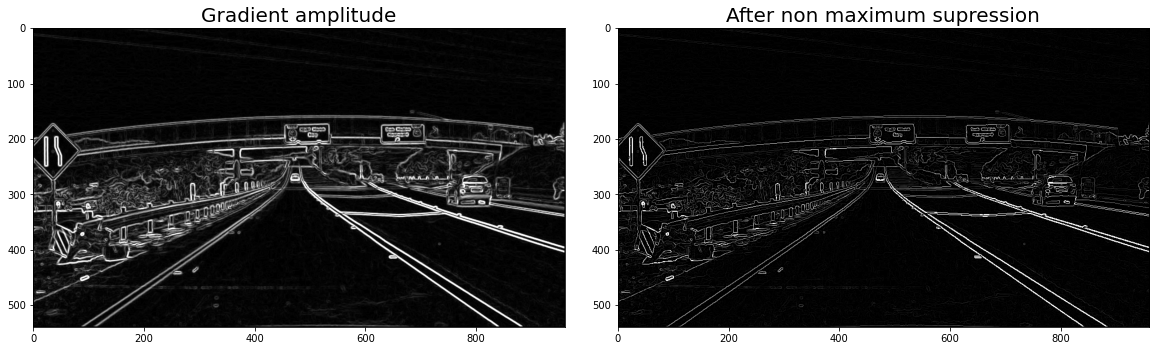

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

plt.subplot(1,2,1)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(gradient, cmap='gray')

plt.subplot(1,2,2)
plt.title('After non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.show()

## Step 4. Thresholding edges

In [ ]:
def seperate(img, minimum = 60, maximum = 180):
    output = img.copy()
    output[(output<maximum)*(output>=minimum)]=minimum
    output[output>=maximum]=255
    output[output<minimum] = 0   
    return output
weak = 50
thresholding = seperate(After_non_maximum_supression, minimum = weak, maximum = weak*3)

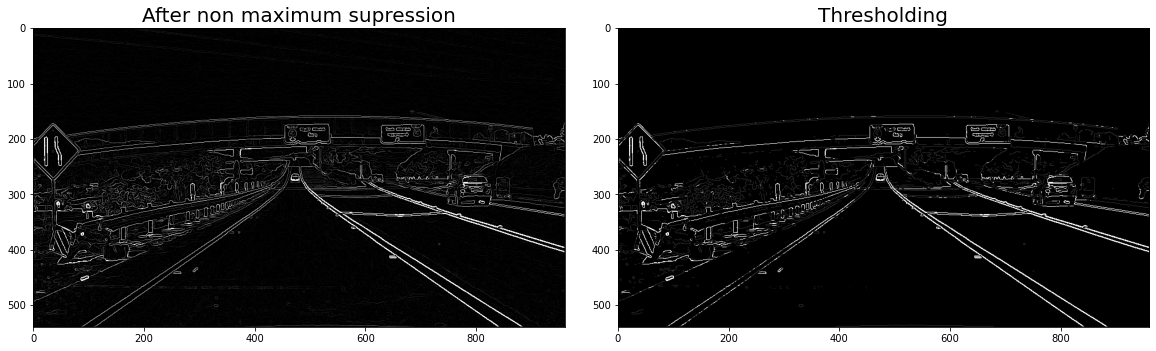

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

plt.subplot(1,2,2)
plt.title('Thresholding',fontsize=20)
plt.imshow(thresholding, cmap='gray')

plt.subplot(1,2,1)
plt.title('After non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.show()

## Step 5. Hysteresis

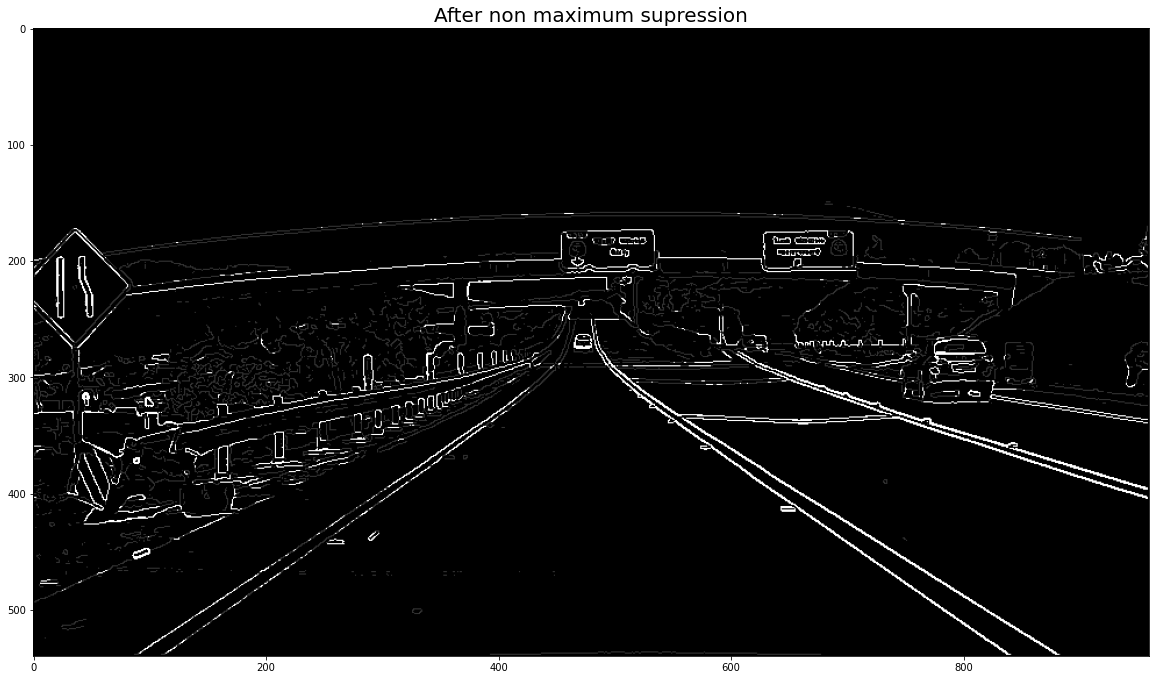

In [ ]:
fig = plt.figure(figsize=(20,12))
plt.title('After non maximum supression',fontsize=20)
plt.imshow(thresholding, cmap='gray')
plt.show()

In [ ]:
def Connect(img,weak=60):
  height,width = img.shape
  output = img.copy()
  xx,yy = np.where(img == 255)
  xx = xx.tolist()
  yy = yy.tolist()
  while len(xx) >0:
    tx = xx.pop()
    ty = yy.pop()
    if tx+1 <= height and tx-1>=0 and ty+1<=width and ty-1>=0:
      newx,newy = np.where(output[tx-1: tx+1+1,ty-1:ty+1+1]==weak)
      newx = newx+tx-1
      newy = newy+ty-1    
      if len(newx)>0:
        output[newx,newy]=255
        xx = newx.tolist() + xx
        yy = newy.tolist() + yy
  output[output==weak]=0
  return output
dst_img = Connect(thresholding,weak)


<Figure size 1440x864 with 0 Axes>

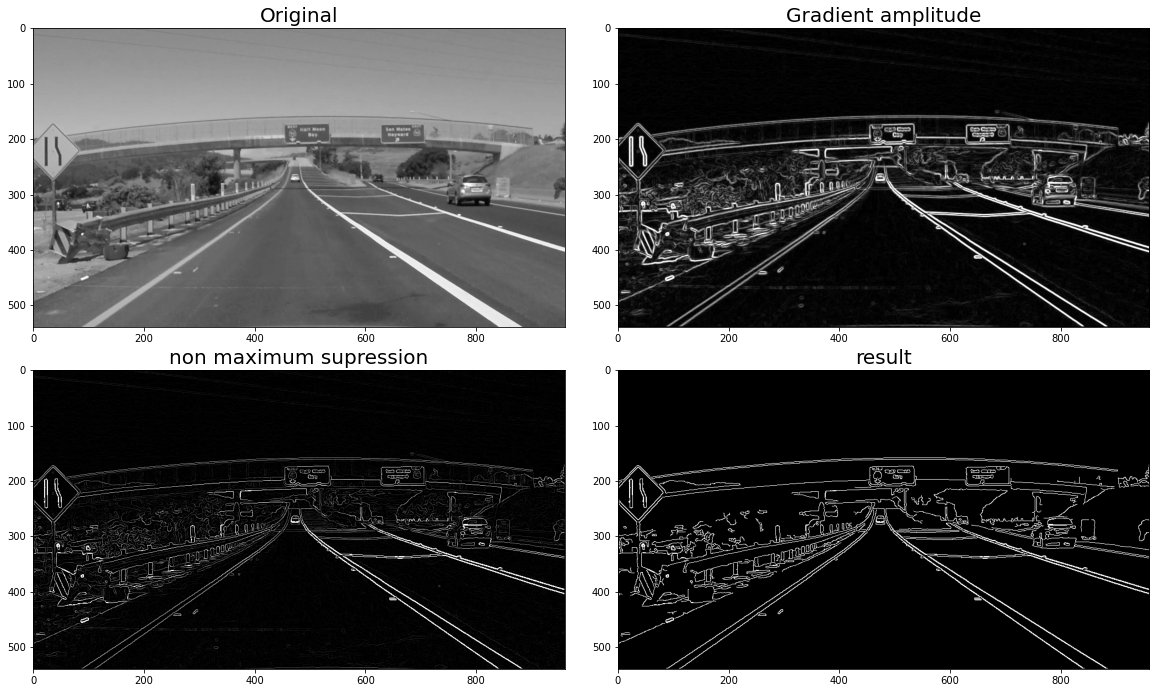

In [ ]:
fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

fig = plt.figure(figsize=(20,12))
fig.subplots_adjust(hspace=0.1, wspace=0.1)
plt.subplot(2,2,1)
plt.title('Original' ,fontsize=20)
plt.imshow(img_org, cmap='gray')

plt.subplot(2,2,2)
plt.title('Gradient amplitude',fontsize=20)
plt.imshow(sobel_m, cmap='gray')

plt.subplot(2,2,3)
plt.title('non maximum supression',fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.subplot(2,2,4)
plt.title('result',fontsize=20)
plt.imshow(dst_img, cmap='gray')

plt.show()

# Canny Edge with OpenCV


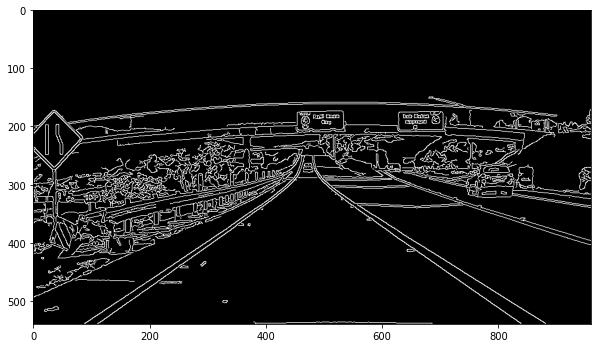

In [ ]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("highway.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()